In [284]:
import pandas as pd
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import stats
from scipy.stats import pearsonr
from scipy import stats

df = pd.read_csv(r"C:\Users\claud\OneDrive\Escritorio\Ironhack\Labs\week 3\Usa-Shootings-and-State-Parties\gva_mass_shootings-2025-10-21.csv")
df.rename(columns={"state":"State"},inplace=True)

df.columns

Index(['incident_id', 'incident_date', 'incident_time', 'updated_date',
       'State', 'city_or_county', 'address', 'business_location_name',
       'latitude', 'longitude', 'killed', 'injured', 'victims_killed',
       'victims_injured', 'suspects_killed', 'suspects_injured',
       'suspects_arrested', 'incident_characteristics', 'sources',
       'date_fixed', 'year'],
      dtype='object')

In [264]:
years=list(range(2014,2025))
def get_edu(year):
    url_edu = f"https://api.census.gov/data/{year}/acs/acs1"
    params = {
        "get": "NAME,B15003_001E,B15003_002E,B15003_003E,B15003_004E,B15003_005E,"
        "B15003_006E,B15003_017E,B15003_022E,B15003_023E,B15003_025E",
        "for": "state:*"}
    response_1 = requests.get(url_edu, params=params)
    if response_1.status_code != 200:
        print(f"⚠️ {year}: HTTP {response_1.status_code} – skipping year")
        return pd.DataFrame()
    if not response_1.text.strip().startswith('[['):
        print(f"⚠️ {year}: invalid or empty response – skipping year")
        return pd.DataFrame()

    try:
        data = response_1.json()
    except Exception:
        print(f"⚠️ {year}: cannot decode JSON – skipping year")
        return pd.DataFrame()

    data = response_1.json()
    df_edu = pd.DataFrame(data[1:], columns=data[0])
    num_col=[column for column in df_edu.columns if column.startswith("B15003_")]
    df_edu[num_col] = df_edu[num_col].apply(pd.to_numeric, errors="coerce")

    df_edu = df_edu.rename(columns={
        "NAME": "State",
        "B15003_001E": "Population_25plus",
        "B15003_002E": "No_Schooling_Completed",
        "B15003_003E": "Nursery_to_4th_Grade",
        "B15003_004E": "5th_to_6th_Grade",
        "B15003_005E": "7th_to_8th_Grade",
        "B15003_006E": "9th_Grade",
        "B15003_017E": "High_School_Graduate",
        "B15003_022E": "Bachelor_Degree",
        "B15003_023E": "Master_Degree",
        "B15003_025E": "Doctorate_Degree","state": "State_Code"})

    col_min_studies=["No_Schooling_Completed",
        "Nursery_to_4th_Grade",
        "5th_to_6th_Grade",
        "7th_to_8th_Grade",
        "9th_Grade"]

    df_edu["Without Min Studies"] = df_edu[col_min_studies].sum(axis=1)

    df_edu.drop(columns=["No_Schooling_Completed",
     "Nursery_to_4th_Grade",
     "5th_to_6th_Grade",
     "7th_to_8th_Grade",
     "9th_Grade","State_Code"], inplace=True)
   
    df_edu["year"]=year
   
    df_edu = df_edu[[
        "year", "State", "Population_25plus",
        "Without Min Studies", "High_School_Graduate",
        "Bachelor_Degree", "Master_Degree", "Doctorate_Degree"
    ]]
    return df_edu
frame=[]
for year in years:
    print(f"Fetching {year}...")
    df_year = get_edu(year)
    if not df_year.empty:
        frame.append(df_year)
df_edu = pd.concat(frame, ignore_index=True)
df_edu



Fetching 2014...
Fetching 2015...
Fetching 2016...
Fetching 2017...
Fetching 2018...
Fetching 2019...
Fetching 2020...
⚠️ 2020: HTTP 404 – skipping year
Fetching 2021...
Fetching 2022...
Fetching 2023...
Fetching 2024...


,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree
0,2014,Alabama,3256766,48873,847523,478058,201391,33082
1,2014,Alaska,465149,4144,108523,85634,33103,4304
2,2014,Arizona,4436226,77042,899108,765784,328400,53578
3,2014,Arkansas,1968414,25814,568437,272411,104636,19380
4,2014,California,25654292,814956,4768478,5120162,2035257,394265
...,...,...,...,...,...,...,...,...
515,2024,Washington,5631460,105363,975478,1372926,683345,113323
516,2024,West Virginia,1268689,14987,420214,187714,88027,13183
517,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628
518,2024,Wyoming,409344,4684,90634,82918,35122,8475


In [265]:
def total_pop(year):
    url = f"https://api.census.gov/data/{year}/acs/acs1"
    params = {"get": "NAME,B01003_001E", "for": "state:*"}
    r = requests.get(url, params=params)
    if r.status_code != 200:
        return pd.DataFrame()
    if not r.text.strip().startswith("[["):
        return pd.DataFrame()
    data= r.json()
    df_pop=pd.DataFrame(data[1:],columns=data[0])
    df_pop.rename(columns={
        "NAME": "State",
        "state": "State_Code",
        "B01003_001E": "Total_Population"},inplace=True)
    df_pop["year"]= year
    df_pop["Total_Population"] = pd.to_numeric(df_pop["Total_Population"],errors="coerce")
    return df_pop[["year","State","State_Code","Total_Population"]]


In [266]:
frames=[]
for year in years:
    edu=get_edu(year)
    pop=total_pop(year)
    if not edu.empty and not pop.empty:
        merged_edu=pd.merge(edu,pop, on=["year","State"],how="left")
        frames.append(merged_edu)
df_eduPop=pd.concat(frames,ignore_index=True)
df_eduPop.drop(columns=["State_Code"],inplace=True)
df_eduPop

⚠️ 2020: HTTP 404 – skipping year


,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree,Total_Population
0,2014,Alabama,3256766,48873,847523,478058,201391,33082,4849377
1,2014,Alaska,465149,4144,108523,85634,33103,4304,736732
2,2014,Arizona,4436226,77042,899108,765784,328400,53578,6731484
3,2014,Arkansas,1968414,25814,568437,272411,104636,19380,2966369
4,2014,California,25654292,814956,4768478,5120162,2035257,394265,38802500
...,...,...,...,...,...,...,...,...,...
515,2024,Washington,5631460,105363,975478,1372926,683345,113323,7958180
516,2024,West Virginia,1268689,14987,420214,187714,88027,13183,1769979
517,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,5960975
518,2024,Wyoming,409344,4684,90634,82918,35122,8475,587618


In [267]:
df_eduShoothing=pd.merge(df_edu,df,on=["year","State"])
df_eduShoothing.drop(columns=["sources","date_fixed","incident_date","incident_id","updated_date","business_location_name","longitude","latitude","address"],inplace=True)
df_eduShoothing

,year,State,Population_25plus,Without Min Studies,High_School_Graduate,Bachelor_Degree,Master_Degree,Doctorate_Degree,incident_time,city_or_county,killed,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics
0,2014,Alabama,3256766,48873,847523,478058,201391,33082,NaN,Huntsville,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
1,2014,Alabama,3256766,48873,847523,478058,201391,33082,NaN,Opp,1,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
2,2014,Alaska,465149,4144,108523,85634,33103,4304,NaN,Anchorage,0,6,0,6,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
3,2014,Arizona,4436226,77042,899108,765784,328400,53578,2:00 AM,Phoenix,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
4,2014,Arkansas,1968414,25814,568437,272411,104636,19380,11:26 PM,Pine Bluff,1,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,12:30 AM,Milwaukee,1,8,1,8,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a..."
4569,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,5:00 AM,Milwaukee,0,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
4570,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,1:30 AM,Milwaukee,0,4,0,4,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict..."
4571,2024,Wisconsin,4172638,48054,1057997,943201,362471,61628,2:25 PM,Milwaukee,0,4,0,4,0,0,2,"Shot - Wounded/Injured, Child Involved Inciden..."


In [268]:
incidents_by_state = (
    df.groupby(["year", "State"])
      .size()
      .reset_index(name="incident_count")
)
incidents_by_state= incidents_by_state.sort_values(by="incident_count",ascending=False)

top_20=incidents_by_state
top_20

,year,State,incident_count
290,2021,Illinois,86
246,2020,Illinois,68
400,2023,Texas,65
333,2022,Illinois,58
317,2021,Texas,57
...,...,...,...
2,2014,Arizona,1
1,2014,Alaska,1
485,2025,Utah,1
488,2025,West Virginia,1


In [275]:
def state_summary(df,df_eduPop,state,year):
    incidents=(df[(df["State"]==state)&(df["year"]==year)].copy())
    edu=(df_eduPop[(df_eduPop["State"]==state)&(df_eduPop["year"]==year)].copy())

    if edu.empty:
        print(f"No data for {state} and {year}")
        return
    n_incidents=incidents.shape[0]
    n_incidents = incidents.shape[0]
    total_killed = incidents["killed"].sum()
    total_injured = incidents["injured"].sum()
    total_victims = total_killed + total_injured

    edu["%Pop_over_25_vs_Total"]=(edu["Population_25plus"]/edu["Total_Population"]*100).round(2)
    edu["%Without_Min_Studies"]=(edu["Without Min Studies"]/edu["Population_25plus"]*100).round(2)
    edu["%HighSchool"]=(edu["High_School_Graduate"]/edu["Population_25plus"]*100).round(2)
    edu["%Bachelor"]=(edu["Bachelor_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Master_Degree"]=(edu["Master_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Doctorate_Degree"]=(edu["Doctorate_Degree"]/edu["Population_25plus"]*100).round(2)
    edu["%Deadliest"]=(total_killed/total_victims*100).round(2)
    edu.drop(columns=["High_School_Graduate","Bachelor_Degree","Master_Degree","Doctorate_Degree","Without Min Studies"],inplace=True)
   
    edu["Incident_Count"] = n_incidents
    edu["Total_Killed"] = total_killed
    edu["Total_Injured"] = total_injured
    edu["Total_Victims"] = total_victims
    
    edu["Incidents_per_100k"] = n_incidents / edu["Total_Population"] * 100000
    
    print(f"{state}({year}) number of indicents: {n_incidents}")
    
    return edu


In [290]:
results=[]
for _,row in top_20.iterrows():
    year=row["year"]
    state=row["State"]
    analysis=state_summary(df,df_eduPop,state,year)
    if analysis is not None and not analysis.empty:
        results.append(analysis)
   
df_top20_analysis=pd.concat(results,ignore_index=True)
df_top20_analysis


    

Illinois(2021) number of indicents: 86
No data for Illinois and 2020
Texas(2023) number of indicents: 65
Illinois(2022) number of indicents: 58
Texas(2021) number of indicents: 57
Illinois(2023) number of indicents: 51
California(2023) number of indicents: 51
Texas(2022) number of indicents: 50
California(2019) number of indicents: 49
California(2022) number of indicents: 49
California(2016) number of indicents: 45
California(2021) number of indicents: 45
Illinois(2016) number of indicents: 42
Illinois(2019) number of indicents: 41
California(2014) number of indicents: 40
No data for California and 2020
No data for New York and 2020
California(2017) number of indicents: 38
New York(2021) number of indicents: 37
Illinois(2017) number of indicents: 37
Illinois(2024) number of indicents: 36
California(2024) number of indicents: 35
Illinois(2018) number of indicents: 35
California(2018) number of indicents: 35
Pennsylvania(2023) number of indicents: 35
Pennsylvania(2021) number of indicent

,year,State,Population_25plus,Total_Population,%Pop_over_25_vs_Total,%Without_Min_Studies,%HighSchool,%Bachelor,%Master_Degree,%Doctorate_Degree,%Deadliest,Incident_Count,Total_Killed,Total_Injured,Total_Victims,Incidents_per_100k
0,2021,Illinois,8730697,12671469,68.90,1.89,21.49,22.13,11.02,1.55,13.84,86,62,386,448,0.678690
1,2023,Texas,20029447,30503301,65.66,3.15,19.86,21.59,9.31,1.42,23.65,65,83,268,351,0.213092
2,2022,Illinois,8692839,12582032,69.09,2.12,21.40,22.47,11.14,1.62,16.45,58,51,259,310,0.460975
3,2021,Texas,19224688,29527941,65.11,3.07,20.25,21.21,8.66,1.38,22.77,57,69,234,303,0.193038
4,2023,Illinois,8710996,12549689,69.41,2.21,21.42,22.77,11.37,1.60,19.57,51,54,222,276,0.406385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2024,Nebraska,1326807,2005466,66.16,2.24,21.93,22.32,9.40,1.64,12.50,1,1,7,8,0.049864
399,2015,Nevada,1968167,2890845,68.08,1.88,24.07,15.49,5.70,0.93,25.00,1,1,3,4,0.034592
400,2015,Montana,706329,1032949,68.38,0.54,27.06,20.41,7.09,1.43,100.00,1,5,0,5,0.096810
401,2014,Arizona,4436226,6731484,65.90,1.74,20.27,17.26,7.40,1.21,25.00,1,1,3,4,0.014856


In [ ]:
summary_pivot = df_top20_analysis.pivot_table(
    index="State",
    columns="year",
    values=[
        "Incidents_per_100k",
        "%Without_Min_Studies",
        "%HighSchool"
    ],
    aggfunc="mean"  
)
summary_pivot

%HighSchool                                            \
year                        2014   2015   2016   2017   2018   2019   2021   
State                                                                        
Alabama                    26.02  25.10  25.19  25.69  25.41  25.67  26.16   
Alaska                     23.33    NaN    NaN    NaN    NaN    NaN  22.50   
Arizona                    20.27  20.36  19.99  20.16  20.04  19.56  19.43   
Arkansas                   28.88  27.68  27.74  27.74  28.22  28.53  28.11   
California                 18.59  18.54  18.19  18.51  18.39  18.29  18.25   
Colorado                   17.87  17.92  17.97  17.41  16.96  17.06  16.29   
Connecticut                24.26  24.15  24.21  24.04  23.84  23.53  22.44   
Delaware                     NaN  26.25  28.48  29.13  30.31  26.68  25.12   
District of Columbia       15.41  14.78  15.41  14.63  13.57  13.36  12.49   
Florida                    25.34  24.98  24.68  24.71  24.52  24.15  23.39   
Georgia                    23.61  23.35  22.85  23.32  23.10  22.76  21.92   
Hawaii                       NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Idaho                        NaN    NaN    NaN    NaN    NaN    NaN  22.00   
Illinois                   22.99  23.14  22.42  22.48  22.45  22.26  21.49   
Indiana                    29.10  29.21  28.48  27.42  28.09  28.58  27.83   
Iowa                         NaN  27.90    NaN  26.50    NaN  27.10  26.32   
Kansas                       NaN  22.36  22.17  21.97  21.32  22.11  21.30   
Kentucky                   26.61  26.76  25.69  26.31  25.94  26.73  26.15   
Louisiana                  28.65  28.58  28.61  28.75  28.90  28.45  27.29   
Maine                      27.42    NaN    NaN  26.01    NaN    NaN    NaN   
Maryland                   22.58  21.99  22.19  21.40  21.07  21.60  20.78   
Massachusetts              22.08  22.33  21.66  21.58  20.61  20.94  19.91   
Michigan                   25.59  25.33  25.18  25.01  24.67  25.13  24.70   
Minnesota                  22.55  22.25  22.04  21.74  21.14  21.42  20.21   
Mississippi                23.92  24.49  24.40  24.22  24.02  23.75  23.81   
Missouri                   26.58  26.39  26.29  26.16  25.83  26.35  26.29   
Montana                      NaN  27.06    NaN  23.48    NaN  23.63    NaN   
Nebraska                     NaN  23.47    NaN    NaN  22.35  22.19  21.63   
Nevada                     24.11  24.07  24.82  24.80  23.69  23.48  23.19   
New Hampshire                NaN    NaN    NaN    NaN    NaN    NaN  22.52   
New Jersey                 25.75  25.99  24.97  24.74  23.94  24.52  22.85   
New Mexico                 21.78  21.57  22.33  22.05  21.42  21.70  21.23   
New York                   22.71  22.62  22.24  22.27  21.97  21.82  20.46   
North Carolina             22.28  21.94  21.41  21.58  21.19  21.39  20.76   
North Dakota                 NaN    NaN    NaN    NaN    NaN    NaN    NaN   
Ohio                       30.20  29.89  29.45  29.45  28.74  28.75  28.86   
Oklahoma                   26.42  26.64  26.22  26.20  26.35  26.16  25.67   
Oregon                     19.69  18.74  18.43    NaN    NaN  18.78  17.56   
Pennsylvania               32.42  31.64  31.25  31.13  30.71  30.55  29.26   
Rhode Island               23.94  23.48    NaN    NaN    NaN    NaN  22.60   
South Carolina             25.76  24.98  24.64  25.01  25.27  24.12  24.03   
South Dakota               26.40  26.68    NaN    NaN    NaN    NaN  24.48   
Tennessee                  27.03  26.92  26.49  26.60  26.15  25.87  25.54   
Texas                      20.64  20.83  20.82  20.75  20.58  20.90  20.25   
Utah                       20.31    NaN    NaN  19.38  19.62    NaN  19.05   
Vermont                      NaN  25.30    NaN    NaN    NaN    NaN    NaN   
Virginia                   20.70  20.55  20.05  20.28  20.08  19.69  20.08   
Washington                 18.89  18.94  18.35  18.41  18.13  18.06  17.70   
West Virginia                NaN    NaN  32

In [ ]:
df_top20_analysis = df_top20_analysis.sort_values(
    by="Incidents_per_100k", ascending=False
).reset_index(drop=True)

top_20=incidents_by_state.head(20)

In [ ]:
casualty_summary = (
    df_top20_analysis.groupby("State")[["Incident_Count", "Total_Killed", "Total_Injured", "Total_Victims"]]
    .sum()
    .sort_values(by="Total_Killed", ascending=False)
)

casualty_summary.head(10)

,Incident_Count,Total_Killed,Total_Injured,Total_Victims
State,,,,
Texas,331,540,1371,1911
California,414,505,1637,2142
Illinois,438,353,1878,2231
Florida,266,350,1178,1528
Pennsylvania,222,209,896,1105
Georgia,191,205,744,949
Ohio,178,190,755,945
Louisiana,210,168,925,1093
North Carolina,143,159,521,680


For Drop outs in Min Studies

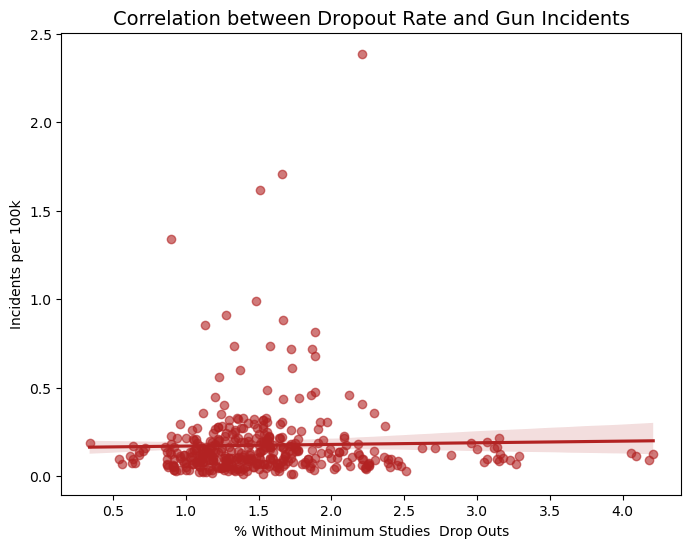

In [288]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Without_Min_Studies",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Without Minimum Studies  Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [ ]:
r, p = stats.pearsonr(
    df_top20_analysis["%Without_Min_Studies"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print(" Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.025
🔹 p-value: 0.6203
No significant correlation found.


No significant correlation found.


Drop outs HighSchool

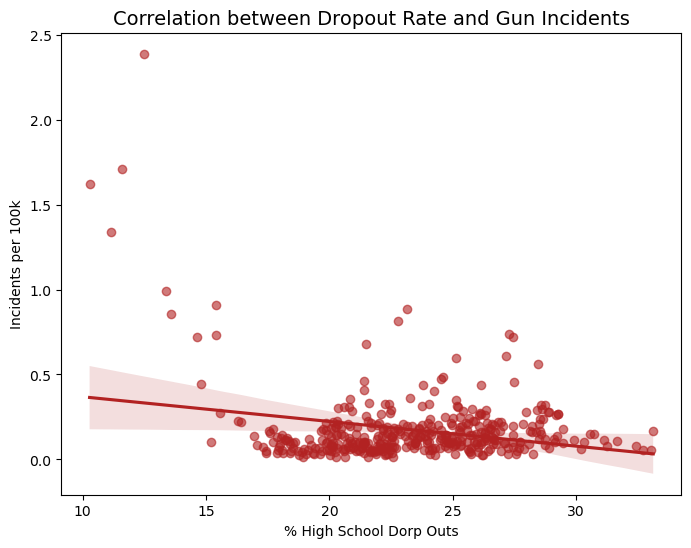

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%HighSchool",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% High School Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [ ]:
r, p = stats.pearsonr(
    df_top20_analysis["%HighSchool"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: -0.251
🔹 p-value: 0.0000
Statistically significant correlation.


AS the drop out in HighSchool decreases, the number of incidents per 100 k  decreases

For drop outs in Bachelors

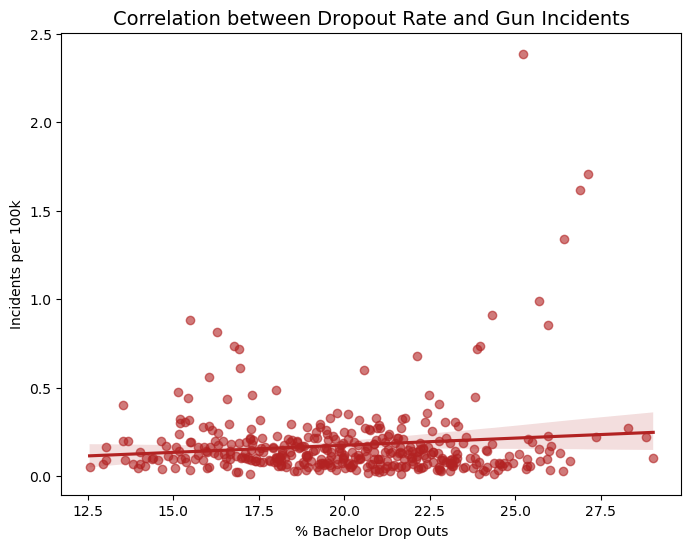

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Bachelor",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Bachelor Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [ ]:
r, p = stats.pearsonr(
    df_top20_analysis["%Bachelor"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.120
🔹 p-value: 0.0159
Statistically significant correlation.


AS the drop outs in Bachelors increases, the incidents per 100 k increases

Drop outs in Master Degrees

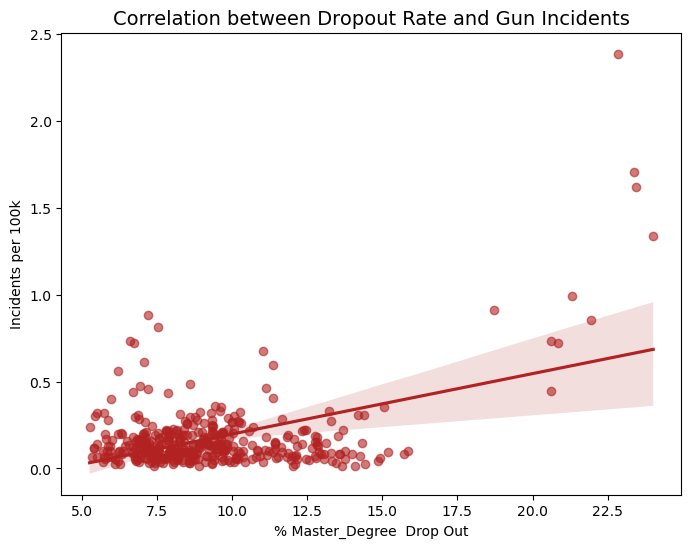

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Master_Degree",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Master_Degree  Drop Out")
plt.ylabel("Incidents per 100k")
plt.show()

In [ ]:
r, p = stats.pearsonr(
    df_top20_analysis["%Master_Degree"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.479
🔹 p-value: 0.0000
Statistically significant correlation.


As the drop outs in Masters degree increases, the incidents per 100 k increases


Doctorate Degree DropOuts

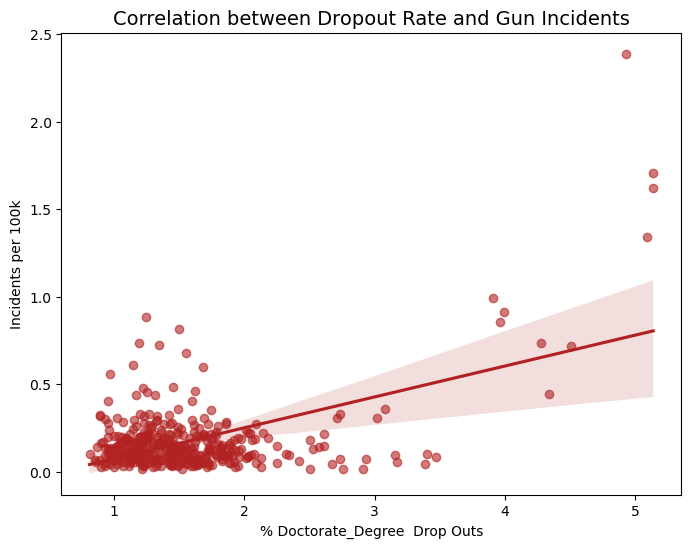

In [286]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_top20_analysis,
    x="%Doctorate_Degree",
    y="Incidents_per_100k",
    color="firebrick",
    scatter_kws={'alpha':0.6}
)
plt.title("Correlation between Dropout Rate and Gun Incidents", fontsize=14)
plt.xlabel("% Doctorate_Degree  Drop Outs")
plt.ylabel("Incidents per 100k")
plt.show()

In [ ]:
r, p = stats.pearsonr(
    df_top20_analysis["%Doctorate_Degree"].dropna(),
    df_top20_analysis["Incidents_per_100k"].dropna()
)

print(f"🔹 Pearson correlation: {r:.3f}")
print(f"🔹 p-value: {p:.4f}")

if p < 0.05:
    print("Statistically significant correlation.")
else:
    print("No significant correlation found.")

🔹 Pearson correlation: 0.534
🔹 p-value: 0.0000
Statistically significant correlation.


AS the drop outs in Doctrorate increases, the incidents per 100 k increases

Map with deadliest states

In [ ]:

import plotly.express as px

# Compute averages by state
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Deadliest": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Deadliest": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Mao n incidents and drop out highschool

In [278]:

import plotly.express as px

# Compute averages by state
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%HighSchool": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%HighSchool": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Map Drop Out Bachelor

In [280]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Bachelor": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Bachelor": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Master degree drop out map

In [281]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Master_Degree": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Master_Degree": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()

Doctorate Map

In [282]:
map_data = df_top20_analysis.groupby("State", as_index=False).agg({
    "Incidents_per_100k": "mean",
    "%Doctorate_Degree": "mean"
})

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Map full names to abbreviations
map_data["State_Code"] = map_data["State"].map(us_state_abbrev)


fig = px.choropleth(
    map_data,
    locations="State_Code",             # use 2-letter codes
    locationmode="USA-states",
    color="Incidents_per_100k",
    hover_name="State",
    hover_data={"%Doctorate_Degree": True, "Incidents_per_100k": True},
    color_continuous_scale="Reds",
    scope="usa",
    title="Gun Incidents per 100k Population by State"
)
fig.show()